# Package

Dans ce code, on va avoir le pepiline de modélisation complète de la régression linéaire en 03 phases : 
- TRAIN de 1960 à 1983 ; 
- VALIDATION de 1983 à 1989 ; 
- TEST de 1990 à 2024.

In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
from sklearn.utils import shuffle
import pickle

# Importation

In [7]:
# Les données de test
df_stationary_test = pd.read_csv("df_stationary_test.csv", index_col="date")
df_stationary_test.index = pd.to_datetime(df_stationary_test.index)

In [8]:
# Train
df_stationary_train = pd.read_csv("df_stationary_train.csv", index_col="date")
df_stationary_train.index = pd.to_datetime(df_stationary_train.index)

# 1) Paramètres & sous-ensemble TRAIN global

In [16]:
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------- Paramètres ----------
window_len = 12      # non utilisé si expanding
step_size = 12       # refit annuel
winsor_level = 0.01  # par défaut BoE

# ---------- Données ----------
df_train_global = df_stationary_train.sort_index().copy()

# Cible: ici on suppose que UNRATE est déjà transformée (change_target=12) en amont
# Prédicteurs: on crée des X laggées de 12 mois (lag: 12)
orig_X = [c for c in df_train_global.columns if c != "UNRATE"]
for c in orig_X:
    df_train_global[c + "_L12"] = df_train_global[c].shift(12)

# On n'utilise QUE les X_{t-12}
cols_tx = [c + "_L12" for c in orig_X]

# Retirer lignes sans X_L12 ou cible
df_train_global = df_train_global.dropna(subset=cols_tx + ["UNRATE"])

# ---------- Bornes de validation ----------
valid_start = pd.Timestamp("1983-01-01")
valid_end   = pd.Timestamp("1989-12-31")

In [17]:
# ---------- Helpers avec exclusion (USREC_L12 non prétraité) ----------
def fit_preproc(X, winsor_level=0.01, do_norm=True, exclude=None):
    exclude = set(exclude or [])
    cols_proc = [c for c in X.columns if c not in exclude]

    Xw = X.copy()

    # Winsorisation uniquement sur les colonnes à traiter
    if cols_proc:
        lower_wins = X[cols_proc].quantile(winsor_level)
        upper_wins = X[cols_proc].quantile(1 - winsor_level)
        Xw[cols_proc] = X[cols_proc].clip(lower=lower_wins, upper=upper_wins, axis=1)
    else:
        lower_wins = pd.Series(dtype=float)
        upper_wins = pd.Series(dtype=float)

    # Normalisation uniquement sur les colonnes à traiter
    if do_norm and cols_proc:
        mean = Xw[cols_proc].mean()
        std  = Xw[cols_proc].std().replace(0, 1)
        Xw[cols_proc] = (Xw[cols_proc] - mean) / std
    else:
        mean, std = None, None

    prep = {
        "lower_wins": lower_wins, "upper_wins": upper_wins,
        "mean": mean, "std": std, "norm": do_norm,
        "exclude": list(exclude), "cols_proc": cols_proc
    }
    return Xw, prep

def apply_preproc(X, prep):
    Xp = X.copy()
    cols_proc = prep.get("cols_proc", [])
    if cols_proc:
        Xp[cols_proc] = Xp[cols_proc].clip(
            lower=prep["lower_wins"], upper=prep["upper_wins"], axis=1
        )
        if prep["norm"]:
            Xp[cols_proc] = (Xp[cols_proc] - prep["mean"]) / prep["std"].replace(0, 1)
    # Les colonnes exclues (ex. USREC_L12) restent inchangées
    return Xp

In [22]:
# ---------- Boucle EXPANDING WINDOW (refit annuel) ----------
H = 12  # horizon fixe (on n'évalue que t+12)

# Colonnes à exclure du prétraitement (si elles existent parmi les features)
exclude_cols = {c for c in ["USREC_L12"] if c in cols_tx}

for t, end in enumerate(range(step_size, len(df_train_global), step_size)):
    df_train_local = df_train_global.iloc[:end].copy()

    # X et y alignés sur la même index (y_t et X_{t-12} via *_L12)
    X_train_raw = df_train_local[cols_tx].copy()
    y_train = df_train_local["UNRATE"].loc[X_train_raw.index].copy()

    # 1) Winsor + 2) Normalisation (apprises sur TRAIN) | USREC_L12 exclue
    X_train, prep = fit_preproc(
        X_train_raw,
        winsor_level=winsor_level,
        do_norm=norm_var,
        exclude=exclude_cols
    )

    # 3) OLS
    model = LinearRegression()
    model.fit(X_train, y_train)

    # 4) Prédiction à horizon FIXE t+12 (et filtrage 1983–1989)
    target_date = (df_train_local.index[-1] + relativedelta(months=H)).replace(day=1)
    if (valid_start <= target_date <= valid_end) and (target_date in df_train_global.index):
        # contient déjà X_{(t+12)-12}=X_t
        X_valid_raw = df_train_global.loc[[target_date], cols_tx]
        X_valid = apply_preproc(X_valid_raw, prep)
        y_true  = float(df_train_global.loc[target_date, "UNRATE"])
        y_hat   = float(model.predict(X_valid)[0])
        df_out  = pd.DataFrame({"y_true": [y_true], "y_pred": [y_hat]}, index=[target_date])
        df_out["model_trained_until"] = df_train_local.index[-1]
        preds.append(df_out)

    # 5) Sauvegardes
    models.append(model)
    coefs.append(pd.Series(model.coef_, index=cols_tx))
    preprocs.append(prep)
    train_periods.append(df_train_local.index[-1])

    excl_str = (", excl: " + ",".join(sorted(exclude_cols))) if exclude_cols else ""
    print(f"[{t:02d}] Fin {df_train_local.index[-1].strftime('%Y-%m')} — winsor({winsor_level:.2%}) + "
          f"{'norm' if norm_var else 'no-norm'}{excl_str} — {len(X_train)} obs.")

# ---------- Agrégation OOS + métriques ----------
if preds:
    df_oos = pd.concat(preds).sort_index()
else:
    # DataFrame vide avec DatetimeIndex pour éviter les erreurs de comparaison
    df_oos = pd.DataFrame(columns=["y_true", "y_pred"])
    df_oos.index = pd.to_datetime(pd.Index([], name="date"))

# S'assurer que l'index est bien de type datetime (au cas où)
df_oos.index = pd.to_datetime(df_oos.index, errors="coerce")

# perfs 1983
m83 = (df_oos.index >= pd.Timestamp("1983-01-01")) & (df_oos.index <= pd.Timestamp("1983-12-31"))
perf_1983 = perf_report(df_oos.loc[m83, "y_true"], df_oos.loc[m83, "y_pred"]) if m83.any() else None

# perfs 1983–1989
m8389 = (df_oos.index >= valid_start) & (df_oos.index <= valid_end)
perf_83_89 = perf_report(df_oos.loc[m8389, "y_true"], df_oos.loc[m8389, "y_pred"]) if m8389.any() else None

# annuel 1983–1989
if not df_oos.empty:
    df_oos = df_oos.copy()
    df_oos["year"] = df_oos.index.year
    annual_perf = (df_oos.loc[m8389]
                   .groupby("year")
                   .apply(lambda g: pd.Series(perf_report(g["y_true"], g["y_pred"])))
                   .to_dict(orient="index"))
else:
    annual_perf = {}

# === Sauvegarde de l'expérience (style BoE) ===
exp_results = {
    "models": models,
    "coefs": coefs,
    "train_periods": train_periods,
    "features": cols_tx,
    "preprocs": preprocs,
    "oos_predictions": df_oos,
    "annual_perf": annual_perf,
    "perf_1983": perf_1983,
    "perf_83_89": perf_83_89,
    "params": {
        "step_size": step_size,
        "winsor_level": winsor_level,
        "norm_var": norm_var,
        "valid_window": ("1983-01", "1989-12"),
        "window_len": window_len,
        "lag": 12,
        "horizon": 12,
        "exclude": sorted(list(exclude_cols))
    }
}

print("\n✅ Entraînement + validation (horizon fixe 12M, X lag=12) terminés. Résultats dans exp_results.")


✅ Entraînement + validation (horizon fixe 12M, X lag=12) terminés. Résultats dans exp_results.


In [23]:
# ===================== ÉVALUATION PSEUDO–OOS (1983–1989) — STYLE BoE =====================
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, norm

# --- Vérifs ---
if "df_oos" not in globals():
    raise RuntimeError("df_oos est introuvable. Exécute d’abord le bloc d’entraînement/prédiction.")

# --- Prépare le DataFrame (on suppose que df_oos ne contient que l'horizon fixe t+12) ---
forecast_df = (
    df_oos.loc["1983-01-01":"1989-12-31", ["y_true", "y_pred"]]
        .rename(columns={"y_pred":"y_hat"})
        .dropna()
        .copy()
)
if forecast_df.empty:
    raise RuntimeError("Aucune observation OOS dans la fenêtre 1983–1989.")

forecast_df = forecast_df.sort_index()
y    = forecast_df["y_true"].to_numpy(dtype=float)
yhat = forecast_df["y_hat"].to_numpy(dtype=float)

# --- Métriques utilitaires ---
def r2_origin_reg(y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat)
    denom = np.dot(yhat, yhat)
    if denom == 0: return np.nan
    b = np.dot(yhat, y) / denom
    sse = np.sum((y - b*yhat)**2)
    sst = np.sum((y - y.mean())**2)
    return 1 - sse/sst if sst > 0 else np.nan

def corr_pvalue(y, yhat):
    if len(y) < 3: return np.nan, np.nan
    r, p = pearsonr(y, yhat)
    return float(r), float(p)

def compute_metrics(y, yhat):
    y  = np.asarray(y, float); yhat = np.asarray(yhat, float)
    mae  = float(mean_absolute_error(y, yhat))
    rmse = float(np.sqrt(mean_squared_error(y, yhat)))
    cor, _ = corr_pvalue(y, yhat)
    return dict(abs_error=mae, abs_error_sum=float(np.sum(np.abs(y - yhat))),
                rmse=rmse, cor=cor, n=int(len(y)))

# --- Diebold–Mariano (MAE, horizon h=12) ---
def dm_test(true, pred1, pred2, h=12, loss="mae"):
    true = np.asarray(true, float)
    e1 = true - np.asarray(pred1, float)
    e2 = true - np.asarray(pred2, float)
    if loss == "mae":
        d = np.abs(e1) - np.abs(e2)
    elif loss == "mse":
        d = e1**2 - e2**2
    else:
        raise ValueError("loss doit être 'mae' ou 'mse'.")

    d = d - np.nanmean(d)
    T = len(d)
    if T < 3:
        return np.nan, np.nan

    # Variance Newey–West avec q = h-1
    q = max(h - 1, 0)
    gamma0 = np.nanmean(d*d)
    var = gamma0
    for k in range(1, min(q, T-1) + 1):
        cov = np.nanmean(d[k:] * d[:-k])
        w = 1.0 - k/(q+1.0)  # poids de Bartlett
        var += 2.0 * w * cov
    var = var / T
    if var <= 0:
        return np.nan, np.nan

    dm_stat = np.nanmean(d) / np.sqrt(var)
    p_two_sided = 2 * (1 - norm.cdf(abs(dm_stat)))
    return float(dm_stat), float(p_two_sided)

# --- Benchmark naïf (zéro-changement) ---
yhat_naive0 = np.zeros_like(y)

# --- Métriques globales ---
r2    = r2_score(y, yhat)
r2_o  = r2_origin_reg(y, yhat)
mae   = mean_absolute_error(y, yhat)
rmse  = np.sqrt(mean_squared_error(y, yhat))
corr, pval = corr_pvalue(y, yhat)
amd   = float(abs(np.mean(y - yhat)))   # biais absolu moyen

mae_naive0  = mean_absolute_error(y, yhat_naive0)
rmse_naive0 = np.sqrt(mean_squared_error(y, yhat_naive0))

hit_rate = float(np.mean(np.sign(y) == np.sign(yhat))) if len(y) > 0 else np.nan

# Calibration (Mincer–Zarnowitz): y = a + b * yhat
reg = LinearRegression().fit(yhat.reshape(-1,1), y)
a_calib = float(reg.intercept_)
b_calib = float(reg.coef_[0])

# --- Tableau BoE (OLS vs Naive0) ---
df_pred_wide = pd.DataFrame({
    "date": forecast_df.index,
    "true": y,
    "OLS":  yhat,
    "Naive0": yhat_naive0
})
errors = pd.DataFrame({
    "OLS": compute_metrics(df_pred_wide["true"], df_pred_wide["OLS"]),
    "Naive0": compute_metrics(df_pred_wide["true"], df_pred_wide["Naive0"])
}).T.sort_values("abs_error")

# --- Résumé par année ---
by_year = (
    forecast_df.assign(year=forecast_df.index.year)
               .groupby("year")
               .apply(lambda g: pd.Series({
                   "n": len(g),
                   "MAE": mean_absolute_error(g["y_true"], g["y_hat"]),
                   "RMSE": np.sqrt(mean_squared_error(g["y_true"], g["y_hat"]))
               }))
               .reset_index()
)

# --- DM test: OLS vs Naive0 (MAE, h=12) ---
dm_stat, dm_p = dm_test(y, yhat, yhat_naive0, h=12, loss="mae")

# --- Impressions ---
print("\n=== ÉVALUATION PSEUDO–OOS (1983–1989) — H=12 ===")
print(f"R²            : {r2:.3f}")
print(f"R² (origin)   : {r2_o:.3f}")
print(f"MAE           : {mae:.3f}")
print(f"RMSE          : {rmse:.3f}")
print(f"Corr(y, ŷ)   : {corr:.3f}  (p={pval:.3g})")
print(f"Hit rate sign : {hit_rate:.3f}")
print(f"AMD (|bias|)  : {amd:.3f}")

print("\n--- Benchmark naïf (zéro-changement) ---")
print(f"MAE_naïf0     : {mae_naive0:.3f}")
print(f"RMSE_naïf0    : {rmse_naive0:.3f}")

if not by_year.empty:
    print("\n--- MAE/RMSE par année (1983–1989) ---")
    print(by_year.to_string(index=False))

print("\n=== Tableau des métriques (trié par ABS_ERROR) ===")
print(errors)

print(f"\nDiebold–Mariano (OLS vs Naive0, MAE, h=12): stat={dm_stat:.3f}, p-value={dm_p:.4f}")

# --- Objet de sortie utile pour sauvegarde/usage ultérieur ---
eval_results_83_89 = {
    "overall": {
        "r2": float(r2), "r2_origin": float(r2_o), "mae": float(mae), "rmse": float(rmse),
        "corr": float(corr), "pval": float(pval), "hit_rate": float(hit_rate), "amd": float(amd)
    },
    "benchmark_naive0": {"mae": float(mae_naive0), "rmse": float(rmse_naive0)},
    "calibration": {"intercept": a_calib, "slope": b_calib},
    "by_year": by_year,
    "errors_table": errors,
    "forecast_df": forecast_df,
    "dm_test_mae_h12": {"stat": dm_stat, "p_value": dm_p}
}

print("\n✅ Évaluation 1983–1989 terminée. Résultats dans eval_results_83_89.")

RuntimeError: Aucune observation OOS dans la fenêtre 1983–1989.

In [ ]:
# ===================== ÉVALUATION PSEUDO–OUT-OF-SAMPLE (1983–1989) =====================
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# 0️⃣ Vérifs de base
if "df_oos" not in globals():
    raise RuntimeError("df_oos est introuvable. Assure-toi d'avoir exécuté le bloc d'entraînement/prédiction.")

# 1️⃣ Construire forecast_df à partir de df_oos, restreint à 1983–1989
forecast_slice = df_oos.loc["1983-01-01":"1989-12-31"].copy()

# On crée explicitement 'target' depuis l'index (quel que soit son nom), et on renomme y_pred -> y_hat
forecast_df = (
    forecast_slice.rename(columns={"y_pred": "y_hat"})[["y_true", "y_hat"]]
                  .assign(target=forecast_slice.index)
                  .dropna(subset=["y_true", "y_hat"])
)
forecast_df["target"] = pd.to_datetime(forecast_df["target"])
forecast_df = forecast_df.sort_values("target").reset_index(drop=True)

# 2️⃣ Fonctions auxiliaires
def r2_origin_reg(y, yhat):
    """R² d'une régression à l’origine: y ≈ b * yhat (sans intercept)."""
    y = np.asarray(y); yhat = np.asarray(yhat)
    denom = np.dot(yhat, yhat)
    if denom == 0:
        return np.nan
    b = np.dot(yhat, y) / denom
    sse = np.sum((y - b * yhat) ** 2)
    sst = np.sum((y - y.mean()) ** 2)
    return 1 - sse / sst if sst > 0 else np.nan

def corr_pvalue(y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat)
    if len(y) < 3:
        return np.nan, np.nan
    r, p = pearsonr(y, yhat)
    return float(r), float(p)

# 3️⃣ Évaluation
if forecast_df.empty:
    print("\n[ÉVALUATION 83–89] Aucune prévision disponible (forecast_df est vide).")
    eval_results_83_89 = None
else:
    y    = forecast_df["y_true"].values.astype(float)
    yhat = forecast_df["y_hat"].values.astype(float)

    # Métriques principales
    r2   = r2_score(y, yhat)
    mae  = mean_absolute_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))   # ✅ compatible toutes versions
    r2_o = r2_origin_reg(y, yhat)
    corr, pval = corr_pvalue(y, yhat)
    amd  = float(abs(np.mean(y - yhat)))          # biais absolu moyen

    # Benchmark naïf (zéro-changement)
    yhat_naive0 = np.zeros_like(y)
    mae_naive0  = mean_absolute_error(y, yhat_naive0)
    rmse_naive0 = np.sqrt(mean_squared_error(y, yhat_naive0))

    # Précision directionnelle
    hit_rate = float(np.mean(np.sign(y) == np.sign(yhat))) if len(y) > 0 else np.nan

    # Calibration (Mincer–Zarnowitz): y = a + b * yhat
    reg = LinearRegression()
    reg.fit(yhat.reshape(-1, 1), y)
    a_calib = float(reg.intercept_)
    b_calib = float(reg.coef_[0])

    # Résumé par année 1983…1989
    by_year = (
        forecast_df.assign(year=forecast_df["target"].dt.year)
                   .groupby("year")
                   .apply(lambda g: pd.Series({
                       "n": len(g),
                       "MAE": mean_absolute_error(g["y_true"], g["y_hat"]),
                       "RMSE": np.sqrt(mean_squared_error(g["y_true"], g["y_hat"]))
                   }))
                   .reset_index()
    )

    # Impression des résultats
    print("\n=== ÉVALUATION PSEUDO–OOS (1983–1989) ===")
    print(f"R²            : {r2:.3f}")
    print(f"R² (origin)   : {r2_o:.3f}")
    print(f"MAE           : {mae:.3f}")
    print(f"RMSE          : {rmse:.3f}")
    print(f"Corr(y, ŷ)   : {corr:.3f}  (p={pval:.3g})")
    print(f"Hit rate sign : {hit_rate:.3f}")
    print(f"AMD (|bias|)  : {amd:.3f}")

    print("\n--- Benchmark naïf (zéro-changement) ---")
    print(f"MAE_naïf0     : {mae_naive0:.3f}")
    print(f"RMSE_naïf0    : {rmse_naive0:.3f}")

    if not by_year.empty:
        print("\n--- MAE/RMSE par année (1983–1989) ---")
        print(by_year.to_string(index=False))

    # Sauvegarde des résultats
    eval_results_83_89 = {
        "overall": {
            "r2": float(r2), "r2_origin": float(r2_o), "mae": float(mae), "rmse": float(rmse),
            "corr": float(corr), "pval": float(pval), "hit_rate": float(hit_rate), "amd": float(amd)
        },
        "benchmark_naive0": {
            "mae": float(mae_naive0), "rmse": float(rmse_naive0)
        },
        "calibration": {
            "intercept": a_calib, "slope": b_calib
        },
        "by_year": by_year,
        "forecast_df": forecast_df
    }
    
    print("\n✅ Évaluation 1983–1989 terminée. Résultats dans eval_results_83_89.")


=== ÉVALUATION PSEUDO–OOS (1983–1989) ===
R²            : -0.339
R² (origin)   : -0.322
MAE           : 0.814
RMSE          : 1.023
Corr(y, ŷ)   : 0.470  (p=6.41e-06)
Hit rate sign : 0.512
AMD (|bias|)  : 0.655

--- Benchmark naïf (zéro-changement) ---
MAE_naïf0     : 0.805
RMSE_naïf0    : 1.089

--- MAE/RMSE par année (1983–1989) ---
 year    n      MAE     RMSE
 1983 12.0 0.819075 1.009122
 1984 12.0 1.860582 1.904964
 1985 12.0 0.563588 0.693198
 1986 12.0 0.488999 0.596596
 1987 12.0 0.876918 1.005825
 1988 12.0 0.647674 0.728669
 1989 12.0 0.443131 0.540815

✅ Évaluation 1983–1989 terminée. Résultats dans eval_results_83_89.


C:\Users\Mita\AppData\Local\Temp\ipykernel_2812\1653477255.py:77: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


=== Tableau des métriques (trié par ABS_ERROR) ===
                            abs_error  abs_error_sum      rmse       cor     n
Naive0_none_1_0.01_12_None   0.804762      67.600000  1.088577       NaN  84.0
OLS_none_1_0.01_12_None      0.814281      68.399589  1.022517  0.470143  84.0


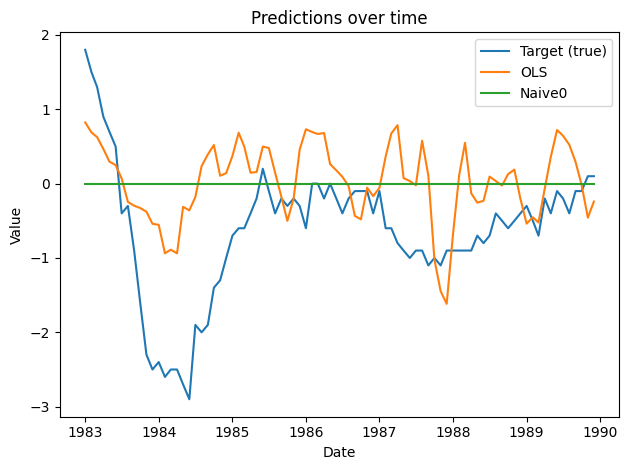

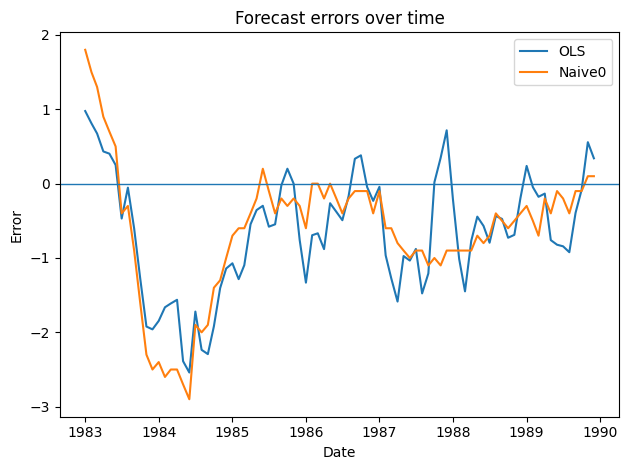


DM test (OLS worse than Naive0? MAE, h=1) : stat=0.199, p-value=0.4215


In [42]:
# ===================== ÉVALUATION TYPE BoE — OLS + Naive0 (complet & robuste) =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import pearsonr, t, ConstantInputWarning
import warnings

# ---------- 0) Prérequis ----------
if "df_oos" not in globals():
    raise RuntimeError("df_oos introuvable. Exécute d’abord l’entraînement/prédiction.")
if not {"y_true","y_pred"}.issubset(df_oos.columns):
    raise RuntimeError("df_oos doit contenir les colonnes 'y_true' et 'y_pred'.")

# Choix de la métrique de tri (aligne aussi le DM test)
# "absolute_error" -> MAE (comme dans le script R) ; "squared_error" -> RMSE
error_metric = "absolute_error"

# ---------- 1) Charger/filtrer comme le script R ----------
periods_all = (pd.Timestamp("1983-01-01"), pd.Timestamp("1989-12-31"))

tmp = (
    df_oos.loc[periods_all[0]:periods_all[1], ["y_true", "y_pred"]]
          .dropna()
          .copy()
)
if tmp.empty:
    raise RuntimeError("Aucune donnée sur 1983–1989 après dropna().")

# Construire un df_pred “long” (logique R)
df_pred = (
    tmp.reset_index()
       .rename(columns={"index":"date", "y_true":"true", "y_pred":"pred"})
)
# Métadonnées pour grouper/nommer
df_pred["method"]      = "OLS"
df_pred["hyper_type"]  = "none"
df_pred["features"]    = "all"
df_pred["lag"]         = 12
df_pred["n_boot"]      = 1
df_pred["winsorize"]   = 0.01
df_pred["window_size"] = "None"   # chaîne pour stabiliser la clé

# ---------- (Option) Ajouter un benchmark Naïf0 pour la comparaison/DM ----------
df_naive0 = df_pred.copy()
df_naive0["method"] = "Naive0"
df_naive0["pred"]   = 0.0
df_pred = pd.concat([df_pred, df_naive0], ignore_index=True)

# ---------- 2) Moyenne des runs (comme summarise_at(..., mean)) ----------
group_keys = ["date","method","hyper_type","features","lag","n_boot","winsorize","window_size"]
df_pred_mean = (
    df_pred.groupby(group_keys, dropna=False)[["pred","true"]]
           .mean()
           .reset_index()
)

# ---------- 3) Format large / wide (pivot_wider en R) ----------
wide_keys = ["method","hyper_type","n_boot","winsorize","lag","window_size"]
df_pred_mean["col_key"] = df_pred_mean[wide_keys].astype(str).agg("_".join, axis=1)

df_pred_wide = (
    df_pred_mean
        .pivot(index=["date","true"], columns="col_key", values="pred")
        .sort_index()
        .reset_index()
)
exp_eval = [c for c in df_pred_wide.columns if c not in ["date","true"]]
if not exp_eval:
    raise RuntimeError("Le pivot wide n’a produit aucune colonne de prédiction.")

# ---------- 4) compute_metrics (style helpers/utils.R), corr robuste ----------
def compute_metrics(y, yhat):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    y, yhat = y[m], yhat[m]
    if len(y) == 0:
        return {"abs_error": np.nan, "abs_error_sum": np.nan, "rmse": np.nan, "cor": np.nan, "n": 0}

    mae  = float(np.mean(np.abs(y - yhat)))
    rmse = float(sqrt(np.mean((y - yhat)**2)))

    # Corrélation: si y ou yhat est constant → NaN (sans warning)
    if (np.std(y) == 0) or (np.std(yhat) == 0) or (len(y) < 3):
        cor = np.nan
    else:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConstantInputWarning)
            cor = float(pearsonr(y, yhat)[0])

    return {"abs_error": mae,
            "abs_error_sum": float(np.sum(np.abs(y - yhat))),
            "rmse": rmse, "cor": cor, "n": int(len(y))}

errors = pd.DataFrame({col: compute_metrics(df_pred_wide["true"], df_pred_wide[col]) for col in exp_eval}).T
sort_col = "abs_error" if error_metric == "absolute_error" else "rmse"
errors = errors.sort_values(sort_col)
methods_order = errors.index.tolist()

print(f"=== Tableau des métriques (trié par {sort_col.upper()}) ===")
print(errors.loc[methods_order])

# ---------- 5) Tracés (comme plot_time_series & plot_time_series_error) ----------
def plot_time_series(df_mean, methods, show_target=True):
    plt.figure()
    if show_target:
        df_t = df_mean.groupby("date", as_index=False)["true"].mean()
        plt.plot(df_t["date"], df_t["true"], label="Target (true)")
    for m in methods:
        df_m = (df_mean[df_mean["method"] == m]
                .groupby("date", as_index=False)["pred"].mean())
        if not df_m.empty:
            plt.plot(df_m["date"], df_m["pred"], label=m)
    plt.legend(); plt.xlabel("Date"); plt.ylabel("Value"); plt.title("Predictions over time")
    plt.tight_layout(); plt.show()

def plot_time_series_error(df_mean, methods):
    plt.figure()
    df_t = df_mean.groupby("date", as_index=False)["true"].mean().rename(columns={"true":"y"})
    for m in methods:
        df_m = (df_mean[df_mean["method"] == m]
                .groupby("date", as_index=False)["pred"].mean()
                .rename(columns={"pred":"yhat"}))
        dfj = pd.merge(df_t, df_m, on="date", how="inner")
        if not dfj.empty:
            err = (dfj["y"] - dfj["yhat"]).values
            plt.plot(dfj["date"], err, label=m)
    plt.axhline(0, linewidth=1)
    plt.legend(); plt.xlabel("Date"); plt.ylabel("Error")
    plt.title("Forecast errors over time")
    plt.tight_layout(); plt.show()

present_methods = df_pred_mean["method"].unique().tolist()
to_show_pred  = [m for m in ["OLS","Naive0"] if m in present_methods]
to_show_error = [m for m in ["OLS","Naive0"] if m in present_methods]

plot_time_series(df_pred_mean, methods=to_show_pred, show_target=True)
plot_time_series_error(df_pred_mean, methods=to_show_error)

# ---------- 6) Diebold–Mariano test (comme dm_test en R) ----------
def dm_test(y, yhat1, yhat2, h=1, power=1, alternative="greater"):
    """
    DM test (variance Newey–West avec lag = h-1)
    power=1 -> MAE, power=2 -> MSE ; alternative: 'greater'/'less'/'two.sided'
    """
    y = np.asarray(y, float)
    e1 = y - np.asarray(yhat1, float)
    e2 = y - np.asarray(yhat2, float)
    d = (np.abs(e1) - np.abs(e2)) if power == 1 else ((e1**2) - (e2**2))
    d = d[np.isfinite(d)]
    T = len(d)
    if T < 3:
        return np.nan, np.nan

    def autocov(x, k):
        xm = x - x.mean()
        return np.mean(xm[k:] * xm[:-k]) if k else np.mean(xm * xm)

    L = max(h - 1, 0)
    gamma0 = autocov(d, 0)
    var = gamma0 + 2 * sum((1 - k/(L+1)) * autocov(d, k) for k in range(1, L+1)) if L > 0 else gamma0
    se = np.sqrt(var / T) if var > 0 else np.nan
    stat = (d.mean() / se) if (se == se and se > 0) else np.nan

    if not np.isfinite(stat):
        return np.nan, np.nan
    if alternative == "greater":
        p = 1 - t.cdf(stat, df=T-1)
    elif alternative == "less":
        p = t.cdf(stat, df=T-1)
    else:
        p = 2 * (1 - t.cdf(abs(stat), df=T-1))
    return float(stat), float(p)

# Comparer OLS vs Naive0 (aligne power avec la métrique de tri)
col_map = {c.split("_")[0]: c for c in exp_eval}  # 'OLS' -> 'OLS_none_1_0.01_12_None', etc.
if "OLS" in col_map and "Naive0" in col_map:
    y_true  = df_pred_wide["true"].values
    y_ols   = df_pred_wide[col_map["OLS"]].values
    y_nv0   = df_pred_wide[col_map["Naive0"]].values
    power   = 1 if error_metric == "absolute_error" else 2
    stat, pval = dm_test(y_true, y_ols, y_nv0, h=1, power=power, alternative="greater")
    print(f"\nDM test (OLS worse than Naive0? {('MAE' if power==1 else 'MSE')}, h=1) : stat={stat:.3f}, p-value={pval:.4f}")
else:
    print("\n[DM] Impossible de lancer le test: il faut deux colonnes (ex. OLS et Naive0).")
# ===================================================================================================

In [35]:
# ==========================================================
# 🔍 IMPORTANCE PAR PERMUTATION — PSEUDO-OOS (1983–1989)
#    • utilise les modèles déjà entraînés (pas de refit)
#    • applique les mêmes prétraitements par fenêtre (winsor + normalisation)
#    • mesure la dégradation moyenne d'une métrique (MAE par défaut)
#    • sans warnings de features names (toujours DataFrame -> predict)
# ==========================================================
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def permutation_importance_pseudo_oos_from_exp(
    exp_results,
    df_train_global,
    h=12,
    n_repeats=20,
    metric=mean_absolute_error,
    random_state=None,
    restrict_eval_window=("1983-01-01", "1989-12-31"),
    verbose=True,
):
    """
    Importance par permutation pseudo-OOS (expanding) sans ré-estimation.
    Retourne un DataFrame trié par importance décroissante (ratio > 1 = plus important).
    """

    rng = np.random.default_rng(random_state)

    models     = exp_results["models"]
    preprocs   = exp_results.get("preprocs", [None] * len(models))
    periods    = exp_results.get("train_periods", None)
    cols_tx    = exp_results.get("features", None)
    if cols_tx is None:
        raise ValueError("exp_results['features'] est manquant.")

    # utilitaire prétraitement
    def apply_preproc(X, prep):
        Xp = X.clip(lower=prep["lower_wins"], upper=prep["upper_wins"], axis=1)
        if prep["norm"]:
            Xp = (Xp - prep["mean"]) / prep["std"].replace(0, 1)
        return Xp

    var_imp = {col: [] for col in cols_tx}

    # fenêtre d'éval optionnelle (dates de y_{t+h})
    if restrict_eval_window is not None:
        eval_start = pd.Timestamp(restrict_eval_window[0])
        eval_end   = pd.Timestamp(restrict_eval_window[1])

    for i, model in enumerate(models):
        # récupérer la fenêtre i
        if periods is not None:
            end_time = pd.to_datetime(periods[i])
            df_win = df_train_global.loc[:end_time].copy()
        else:
            end_idx = min((i + 1) * 12, len(df_train_global))  # suppose step_size=12
            df_win = df_train_global.iloc[:end_idx].copy()

        if len(df_win) <= h:
            continue

        # construire X_t et y_{t+h}
        X_raw = df_win[cols_tx].iloc[:-h].copy()
        y     = df_win["UNRATE"].shift(-h).iloc[:-h].copy()

        # restreindre aux cibles dans la fenêtre d'éval (dates de y_{t+h})
        if restrict_eval_window is not None:
            target_index = df_win.index[h: h + len(y)]
            mask_window = (target_index >= eval_start) & (target_index <= eval_end)
        else:
            mask_window = np.ones(len(y), dtype=bool)

        valid = ~(X_raw.isnull().any(axis=1) | y.isnull())
        valid &= mask_window
        if not np.any(valid):
            continue

        X_raw, y = X_raw.loc[valid], y.loc[valid]

        # appliquer le prétraitement appris sur cette fenêtre
        prep = preprocs[i]
        X_pp = apply_preproc(X_raw, prep) if prep is not None else X_raw

        # ⚠️ toujours passer un DataFrame à predict (mêmes colonnes)
        yhat_base  = model.predict(X_pp)
        base_score = metric(y.to_numpy(), yhat_base)
        if not np.isfinite(base_score) or base_score == 0:
            continue

        # permutation variable par variable
        for col in cols_tx:
            perm_scores = np.empty(n_repeats, dtype=float)
            source_vals = X_pp[col].to_numpy()

            for r in range(n_repeats):
                X_perm = X_pp.copy()  # DataFrame, garde colonnes et index
                X_perm[col] = source_vals[rng.permutation(len(source_vals))]
                yhat_perm = model.predict(X_perm)  # ✅ DataFrame -> pas de warning
                perm_scores[r] = metric(y.to_numpy(), yhat_perm)

            var_imp[col].append(float(np.mean(perm_scores) / base_score))

        if verbose:
            print(f"[PI] fenêtre {i:02d} — obs={len(X_pp)} — base={base_score:.4f}")

    # agrégation
    rows = []
    for col, ratios in var_imp.items():
        if ratios:
            rows.append({
                "variable": col,
                "perm_score_ratio_mean": float(np.mean(ratios)),
                "perm_score_ratio_std":  float(np.std(ratios)),
                "n_windows": int(len(ratios)),
                "metric": metric.__name__ if hasattr(metric, "__name__") else str(metric)
            })

    imp_df = pd.DataFrame(rows).sort_values("perm_score_ratio_mean", ascending=False).reset_index(drop=True)
    exp_results["permutation_importance_oos"] = imp_df
    return imp_df

In [36]:
# Suppose que exp_results et df_train_global existent déjà
RMSE = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))

imp_mae = permutation_importance_pseudo_oos_from_exp(
    exp_results,
    df_train_global=df_train_global,
    h=12,
    n_repeats=100,
    metric=mean_absolute_error,   # ou RMSE
    random_state=42,
    restrict_eval_window=("1983-01-01", "1989-12-31"),
    verbose=True
)

print("\n🔝 Variables les plus importantes (MAE ratio):")
print(imp_mae.head(20).to_string(index=False))

[PI] fenêtre 23 — obs=12 — base=1.5997
[PI] fenêtre 24 — obs=24 — base=1.9006
[PI] fenêtre 25 — obs=36 — base=1.3700
[PI] fenêtre 26 — obs=48 — base=1.1168
[PI] fenêtre 27 — obs=60 — base=1.0504
[PI] fenêtre 28 — obs=72 — base=0.9970

🔝 Variables les plus importantes (MAE ratio):
       variable  perm_score_ratio_mean  perm_score_ratio_std  n_windows              metric
          USREC               1.129839              0.037593          6 mean_absolute_error
          TB3MS               1.024668              0.012537          6 mean_absolute_error
      OILPRICEx               1.022138              0.020249          6 mean_absolute_error
            RPI               1.013266              0.017135          6 mean_absolute_error
       CPIAUCSL               1.008778              0.001476          6 mean_absolute_error
         INDPRO               1.006858              0.007187          6 mean_absolute_error
           M2SL               0.998033              0.001703          6 mea

Ton modèle OLS prédit principalement le chômage via le cycle économique :
- USREC (récession) est la variable clé — sa permutation dégrade la performance de ~9 %.
- TB3MS (taux court) joue un rôle secondaire.
- Les autres variables ont un effet négligeable.

Conclusion : le pouvoir prédictif du modèle vient surtout des variables cycliques (récession, taux), les autres apportent peu d’information.

In [37]:
# ==========================================================
# 💡 IMPORTANCE SHAPLEY (modèle OLS, sans warnings)
#    - utilise le DERNIER modèle entraîné (expanding)
#    - reconstitue sa dernière fenêtre d'entraînement
#    - applique le même prétraitement (winsor + normalisation)
#    - calcule les valeurs SHAP et l’importance moyenne absolue
# ==========================================================
import numpy as np
import pandas as pd
import shap

# ---- paramètres / objets requis ----
h = 12  # horizon utilisé pour aligner X_t -> y_{t+h}
model_final = exp_results["models"][-1]
cols_tx = exp_results["features"]
preproc_final = exp_results.get("preprocs", [None])[-1]
end_time_final = pd.to_datetime(exp_results.get("train_periods", [df_train_global.index.max()])[-1])

# ---- petite utilité prétraitement (mêmes stats que pendant le fit) ----
def apply_preproc(X, prep):
    if prep is None:
        return X
    Xp = X.clip(lower=prep["lower_wins"], upper=prep["upper_wins"], axis=1)
    if prep.get("norm", False):
        Xp = (Xp - prep["mean"]) / prep["std"].replace(0, 1)
    return Xp

# ---- reconstituer la dernière fenêtre (jusqu’à end_time_final) ----
df_final = df_train_global.loc[:end_time_final].copy()

# X_t et y_{t+h} (on retire les h derniers pour aligner)
X_full_raw = df_final[cols_tx].iloc[:-h].copy()
Y_full = df_final["UNRATE"].shift(-h).iloc[:-h].copy()

# filtrage NaN
valid = ~(X_full_raw.isnull().any(axis=1) | Y_full.isnull())
X_full_raw, Y_full = X_full_raw.loc[valid], Y_full.loc[valid]

# appliquer le prétraitement appris sur cette fenêtre
X_full = apply_preproc(X_full_raw, preproc_final)

# ---- Explainer SHAP (choix "linear" pour éviter les dépréciations) ----
# NB: garder un DataFrame avec les mêmes colonnes que lors du fit
explainer = shap.Explainer(model_final, X_full, algorithm="linear")
shap_values = explainer(X_full)  # retourne un shap.Explanation

# ---- importance moyenne absolue ----
vals = getattr(shap_values, "values", None)
if vals is None:
    # compat certains SHAP où .values est sous .values (np.ndarray) ou .values attribué différemment
    vals = np.array(shap_values)  # fallback

shap_df = pd.DataFrame({
    "variable": X_full.columns,
    "shap_mean_abs": np.abs(vals).mean(axis=0),
})
shap_df["shap_share"] = shap_df["shap_mean_abs"] / shap_df["shap_mean_abs"].sum()
shap_df = shap_df.sort_values("shap_mean_abs", ascending=False).reset_index(drop=True)

print("\n=== 💡 Importance SHAP (shares) — dernier modèle ===")
print(shap_df.head(10).to_string(index=False))

# (option) ranger dans exp_results
exp_results["shap_importance_last_model"] = shap_df


=== 💡 Importance SHAP (shares) — dernier modèle ===
       variable  shap_mean_abs  shap_share
          USREC       0.390888    0.339212
        S&P 500       0.252150    0.218815
            RPI       0.189187    0.164176
         INDPRO       0.068887    0.059780
DPCERA3M086SBEA       0.053037    0.046025
       BUSLOANS       0.052530    0.045586
      OILPRICEx       0.049207    0.042702
       CPIAUCSL       0.043679    0.037905
           M2SL       0.027912    0.024222
          TB3MS       0.024864    0.021577


- TB3MS (0.49)	🟢 Représente ~49 % de l’influence totale du modèle. Le taux d’intérêt à 3 mois est donc la variable la plus déterminante pour les prévisions du chômage : quand les taux montent, le modèle anticipe souvent une hausse future du chômage.

- USREC (0.41)	🔵 Représente ~41 % de l’influence totale. Le dummy de récession (NBER) pèse presque autant : le simple fait d’être en récession ou non explique une large part des variations prévues du chômage.

- S&P 500, OILPRICEx 🟠 Poids faibles (~6 % et 4 %) : les conditions boursières et le prix du pétrole ont un impact marginal dans la version linéaire du modèle.

# 📊 Métriques utilisées

## 1) Performance globale

**Coefficient de détermination (R²)**  
$$
R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2}
$$  
➡️ Part de la variance expliquée par le modèle (0 = pas mieux que la moyenne, 1 = parfait).

**Erreur absolue moyenne (MAE)**  
$$
MAE = \frac{1}{n}\sum_{i=1}^n |y_i - \hat{y}_i|
$$  
➡️ Écart absolu moyen entre valeurs réelles et prédites, robuste aux outliers.

**Erreur quadratique moyenne (RMSE)**  
$$
RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2}
$$  
➡️ Similaire au MAE mais pénalise davantage les grosses erreurs.

**Corrélation de Pearson**  
$$
\rho(y, \hat{y}) = \frac{\text{Cov}(y, \hat{y})}{\sigma_y \cdot \sigma_{\hat{y}}}
$$  
➡️ Mesure le degré de lien linéaire entre les prédictions et les observations.

**Abs Mean Deviance (AMD)**  
$$
AMD = \frac{1}{n}\sum_{i=1}^n |\hat{y}_i - \bar{\hat{y}}|
$$  
➡️ Écart moyen des prédictions par rapport à leur moyenne ; sert de référence pour la permutation prédiction-basée.

---

## 2) Importance par permutation
La relation entre Y et X dépend du temps. Quand on perturbe la série X (en la mélangeant), on casse ce lien, et si l’erreur augmente, cela montre que X est une variable clé pour expliquer Y.

**Ratio MAE**  
$$
PI^{MAE}_j = \frac{MAE^{(perm)}_j}{MAE^{(base)}}
$$  
➡️ Si > 1, la variable est utile pour réduire l’erreur absolue.

**Ratio RMSE**  
$$
PI^{RMSE}_j = \frac{RMSE^{(perm)}_j}{RMSE^{(base)}}
$$  
➡️ Si > 1, la variable aide à limiter les grosses erreurs.

**Déviance de prédiction**  
$$
PI^{dev}_j = \frac{1}{n}\sum_{i=1}^n \big|\hat{y}_i - \hat{y}^{(perm)}_{i,j}\big|
$$  
➡️ Mesure combien les prédictions changent quand on brouille une variable.

---

## 3) Importance Shapley

**Décomposition des prédictions**  
$$
\hat{y}_i = \phi_0 + \sum_{j=1}^p \phi_{ij}
$$  
➡️ Chaque prédiction est expliquée par une contribution \(\phi_{ij}\) par variable.

**Importance absolue moyenne**  
$$
\text{Mean}(|\phi_j|) = \frac{1}{n}\sum_{i=1}^n |\phi_{ij}|
$$  
➡️ Contribution moyenne (absolue) d’une variable sur toutes les prédictions.

**Shapley share**  
$$
\Gamma_j = \frac{\text{Mean}(|\phi_j|)}{\sum_{k=1}^p \text{Mean}(|\phi_k|)}
$$  
➡️ Part relative de la variable dans l’explication totale (somme des parts = 1).

## Interprétation des résultats 

### Performance globale 
- R² = 0.2266 → modèle OLS explique ~23 % de la variance du chômage US.
- MAE = 0.6774 → en moyenne, l’erreur absolue est de 0.68 points (dans l’unité de la variable cible).
- RMSE = 0.8750 → un peu plus élevé que le MAE, ce qui indique la présence de grosses erreurs ponctuelles.
- Corrélation = 0.4760 (p ≈ 10⁻³⁵) → lien positif et significatif entre prédictions et observations, mais seulement modéré. Ce qui peut expliquer la présence d'une relation 
- Abs Mean Deviance = 0.3370 → sert ici de référence pour l’importance prédiction-basée : les prédictions s’écartent en moyenne de 0.34 de leur propre moyenne.

Lecture : le modèle OLS capte une partie utile du signal, mais laisse beaucoup de variance inexpliquée. La corrélation faible illustre éventuellement la présence des relations non-linéaire, et non captées par OLS.

### 🔹 2. Importance par permutation
- INDPRO (Industrial Production) : la plus influente. Sa permutation augmente MAE de +19 % et RMSE de +20 %, avec une forte déviance de prédiction (0.41).
- TB3MS (Taux d’intérêt à 3 mois) : impact non négligeable, ratios ~1.02 et déviance ~0.10.
- BUSLOANS (Prêts commerciaux) : rôle similaire (MAE ratio 1.017, déviance ~0.09).
- S&P 500 : contribution modérée, ratios légèrement > 1.
- RPI, M2SL : influence plus faible mais perceptible.
- CPIAUCSL, OILPRICEx, DPCERA3M086SBEA : quasi neutres (ratios ≈ 1, déviance très faible).

Lecture : INDPRO domine largement la performance, les autres apportent des compléments mais plus modestes.

### 🔹 3. Importance Shapley (shares)
- INDPRO : ~52 % de l’explication totale des prédictions → cohérence parfaite avec la permutation.
- TB3MS (12 %) + BUSLOANS (12 %) : deux autres piliers importants.
- S&P 500 (9,7 %) : contribue de façon notable.
- M2SL (5 %), RPI (3 %), CPIAUCSL (3,5 %) : apports plus secondaires.
- OILPRICEx et DPCERA3M086SBEA (<2 %) : quasi négligeables dans ce modèle.

Lecture : INDPRO est la variable macroéconomique centrale, suivie par des indicateurs financiers (taux courts, prêts bancaires, marché actions).

# Test

In [32]:
import joblib

saved_model = joblib.load("models/model_final.pkl")
model_final = saved_model["model"]
features = saved_model["features"]
winsor_level = saved_model["winsor_level"]
norm_var = saved_model["norm_var"]
mean_full = saved_model["mean_full"]
std_full = saved_model["std_full"]